In [1]:
from pycocotools.coco import COCO
from generator import get_generator
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from model import EncoderCNN, DecoderRNN
from nlp_utils import clean_sentence
import tkinter as tk
from tkinter import*
from PIL import Image, ImageTk
from tkinter import filedialog
from shutil import copyfile

%matplotlib inline
#%load_ext autoreload
#%autoreload 2

In [2]:
cocoapi_dir = "C:/Users/ExplosiveTurkey/image_captioning"

# Defining a transform to pre-process the testing images.
transform_test = transforms.Compose(
    [
        transforms.Resize(256),  # smaller edge of image resized to 256
        transforms.RandomCrop(224),  # get 224x224 crop from random location
        transforms.RandomHorizontalFlip(),  # horizontally flip image with probability=0.5
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        ),
    ]
)


# Creating the data loader.
generator = get_generator(transform=transform_test, mode="test", cocoapi_loc=cocoapi_dir)

Vocabulary successfully loaded from vocab.pkl file!


torch.Size([1, 428, 640, 3]) torch.Size([1, 3, 224, 224]) torch.Size([428, 640, 3])


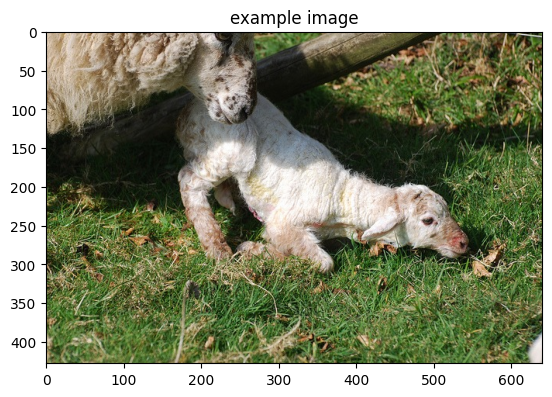

In [3]:
# Obtaining sample image before and after pre-processing.
orig_image, image = next(iter(generator))

print(orig_image.shape, image.shape, np.squeeze(orig_image).shape)

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title("example image")
plt.show()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Specify the saved models to load.
encoder_file = "encoder-3.pkl"
decoder_file = "decoder-3.pkl"

# Select appropriate values for the Python variables below.
embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(generator.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
encoder.eval()
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join("./models", encoder_file), map_location=torch.device('cpu')))
decoder.load_state_dict(torch.load(os.path.join("./models", decoder_file), map_location=torch.device('cpu')))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embed): Embedding(9955, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9955, bias=True)
)

In [6]:
# Moving image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtaining the embedded image features.
features = encoder(image).unsqueeze(1)

print(features.shape)
# Passing the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print("example output:", output)

assert type(output) == list, "Output needs to be a Python list"
assert all([type(x) == int for x in output]), "Output should be a list of integers."
assert all(
    [x in generator.dataset.vocab.idx2word for x in output]
), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

torch.Size([1, 1, 256])
example output: [0, 3, 371, 130, 355, 21, 3, 356, 77, 32, 136, 18, 1]


In [7]:
sentence = clean_sentence(output, generator.dataset.vocab.idx2word)
print("example sentence:", sentence)

assert type(sentence) == str, "Sentence needs to be a Python string!"

example sentence:  a dog is playing with a frisbee in the grass.


In [8]:
def get_prediction(idx2word, i=0, save=False):
    orig_image, image = next(iter(generator))
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)
    sentence = clean_sentence(output, idx2word)
    return sentence

In [38]:
from tkinter import*
from PIL import Image, ImageTk

def quitfrom():
    #quit()
    screen.destroy()
    
def generate():
    caption=get_prediction(generator.dataset.vocab.idx2word, i=1) 
    label.config(text=caption,fg='black',font="Helvetica 16 bold")
    label.update_idletasks()

def sub_main(file,root):
    global filepath
    global screen
    filepath=file
    screen=Toplevel(root)
    screen.title("Image Caption Generator")
    ff1=Frame(screen,bg="yellow",borderwidth=6,relief=GROOVE)
    ff1.pack(side=TOP,fill=X)
    ff2=Frame(screen,bg="grey",borderwidth=6,relief=GROOVE)
    ff2.pack(side=TOP,fill=X)
    
    global ff4
    global label 
    ff4=Frame(screen,bg="white",borderwidth=6,relief=GROOVE)
    ff4.pack(side=TOP,fill=X)
    ff3=Frame(screen,bg="grey",borderwidth=6,relief=GROOVE)
    ff3.pack(side=TOP,fill=X)
    Label(ff1,text="Image Caption Generator",bg="blue",font="Helvetica 16 bold").pack()
    img=Image.open(file)
    img=img.resize((500,400))
    photo=ImageTk.PhotoImage(img)
    Label(ff2,image=photo).pack() 
    label=Label(ff4,text="Caption",font="Helvetica 16 bold")
    label.pack()
    Button(ff3,text="Generate Caption",bg="green",command=generate,height=2,width=40,font="Helvetica 16 bold").pack(side=LEFT)
    Button(ff3,text='Quit',bg="red",command= quitfrom,height=2,width=20,font="Helvetica 16 bold").pack()
    screen.mainloop()

In [39]:
global filedest
def choosephoto():
    #root.destroy()
    filedest=filedialog.askopenfilename(initialdir="images",title="Select Photo",filetypes=((".jpg files","*.jpg",),("jpeg files","*.jpeg")))
    img=Image.open(filedest)
    img.save("C:/Users/ExplosiveTurkey/image_captioning/cocoapi/images/test/1.jpg")
    sub_main(filedest,root)
def quitgui():
    root.destroy()
global root
root=Tk()
root.title("Image Caption Generator")
#root.geometry("500x500")

f1=Frame(root,bg="white",borderwidth=6,relief=GROOVE)
f1.pack(side=TOP,fill=X)
f2=Frame(root,bg="white",borderwidth=6,relief=GROOVE)
f2.pack(side=TOP,fill=X)
Label(f1,text="Image Caption Generator",fg="black",bg="blue",font="Helvetica 16 bold").pack()
btn1=Button(root,text="Choose Photo",command=choosephoto,height=2,width=20,bg='green',font="Helvetica 16 bold",pady=10)
btn1.pack() 

Button(root,text="Quit",command=quitgui,height=2,width=20,bg='red',font="Helvetica 16 bold",pady=10).pack()

root.mainloop() 